# Unet
The model design includes two learning stages. In stage I, each input volume goes through a separate stack of convolutional layers. In stage II, feature maps resulting from stage I are merged, and the results are fed to a deep learning model to arrive at the final outputs.

![title](img/f1.png)

In [1]:
import numpy as np
import xarray as xr

from keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf
from stages import stage1
from unet import unet

2024-05-30 17:42:14.256345: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 17:42:14.414207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Shallow learning (Stage 1)
For Unet and SegnetLite models, stage I shallow learning includes a single convolutional layer with 16 filters for each type of predictors, the outputs of which are then merged and provided as inputs to the respective deep learning model.

In [2]:
stage1_model = stage1(16)

stage1_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                              

#### 2. Unet

In [3]:
unet_model = unet((128,128,48))

In [4]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 48)]       0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 128, 128, 32)         13856     ['input_4[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d_3[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_4[0][0]']            
 D)                                                                                         

#### 3. Combined model (Stage 2)

In [5]:
full_model = Model(inputs=stage1_model.inputs, outputs=unet_model(stage1_model.outputs))

In [6]:
full_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                            

In [7]:
# Define the custom loss function
def custom_loss(y_true, y_pred):
    # Mean Squared Error (MSE)
    mse = (1 / (125*128*128)) * tf.keras.losses.mean_squared_error(y_pred, y_true)

    # Nash-Sutcliffe Efficiency (NSE) component
    numerator = tf.reduce_sum(tf.abs(y_pred - y_true), axis=-1)
    denominator = tf.reduce_sum(tf.abs(y_true - tf.reduce_mean(y_true, axis=-1, keepdims=True)), axis=-1)
    nse = numerator / (denominator + tf.keras.backend.epsilon())
    # Combine MSE and NSE
    combined_loss = 0.5 * mse + 0.5 * nse
    return combined_loss

In [8]:
def custom_nse(y_true, y_pred):
    numerator = tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1, keepdims=True)), axis=-1)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

In [9]:
full_model.compile(optimizer = SGD(learning_rate = 0.01, weight_decay=1e-6, momentum=0.9), loss = 'mean_squared_error', metrics = [ custom_nse ])

In [10]:
full_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                            

#### 4. Model training
Out of a total of 177 monthly data available for the study period, 125 months or 70% is used for training and the rest for testing.

In [11]:
precip_train = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(3,127)])
temp_train = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(3,127)])
twsa_train = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(3,127)])

precip_test = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(127,177)])
temp_test = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(127,177)])
twsa_test = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(127,177)])

mismatch_ds = xr.open_mfdataset('./data/mismatch.nc4')
mismatch = mismatch_ds['norm_mismatch'].to_numpy()[..., np.newaxis]
mismatch_train = mismatch[3:127]
mismatch_test = mismatch[127:177]

print(f'Number of training examples = {precip_train.shape[0]}')
print(f'Number of test examples = {precip_test.shape[0]}')

print(f'Training input shape: {precip_train.shape}')
print(f'Training output shape: {mismatch_train.shape}')
print(f'Test input shape: {precip_test.shape}')
print(f'Test output shape: {mismatch_test.shape}')

Number of training examples = 124
Number of test examples = 50
Training input shape: (124, 128, 128, 3)
Training output shape: (124, 128, 128, 1)
Test input shape: (50, 128, 128, 3)
Test output shape: (50, 128, 128, 1)


In [12]:
full_model.fit([precip_train, temp_train, twsa_train], mismatch_train, epochs = 60, batch_size = 5)

Epoch 1/60
25/25 [==============================] - 9s 302ms/step - loss: 0.5499 - custom_nse: -5499062.5000
Epoch 2/60
25/25 [==============================] - 8s 333ms/step - loss: 0.3841 - custom_nse: -3841389.7500
Epoch 3/60
25/25 [==============================] - 8s 329ms/step - loss: 0.3714 - custom_nse: -3714320.0000
Epoch 4/60
25/25 [==============================] - 9s 347ms/step - loss: 0.3703 - custom_nse: -3703227.0000
Epoch 5/60
25/25 [==============================] - 9s 342ms/step - loss: 0.3654 - custom_nse: -3653997.2500
Epoch 6/60
25/25 [==============================] - 9s 346ms/step - loss: 0.3611 - custom_nse: -3610714.7500
Epoch 7/60
25/25 [==============================] - 10s 391ms/step - loss: 0.3509 - custom_nse: -3508700.5000
Epoch 8/60
25/25 [==============================] - 9s 357ms/step - loss: 0.3449 - custom_nse: -3448550.7500
Epoch 9/60
25/25 [==============================] - 9s 346ms/step - loss: 0.3399 - custom_nse: -3399282.2500
Epoch 10/60
25/25 

In [13]:
preds = full_model.evaluate([precip_test, temp_test, twsa_test], mismatch_test, batch_size=5)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10/10 [==============================] - 2s 129ms/step - loss: 0.7217 - custom_nse: -7217058.0000
Loss = 0.7217057943344116
Test Accuracy = -7217058.0


In [14]:
pred_mismatch = full_model.predict([precip_test, temp_test, twsa_test], batch_size=5)

10/10 [==============================] - 1s 128ms/step


In [15]:
pred_mismatch.shape

(50, 128, 128, 1)

In [16]:
mismatch_ds = xr.open_mfdataset('./data/mismatch.nc4')

In [17]:
pred_mismatch_da = xr.DataArray(np.squeeze(pred_mismatch), coords={'time': mismatch_ds['time'][127:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])

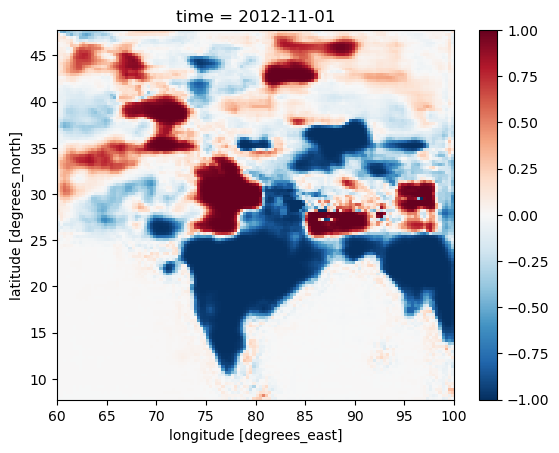

In [25]:
pred_mismatch_da[0,:,:].plot()

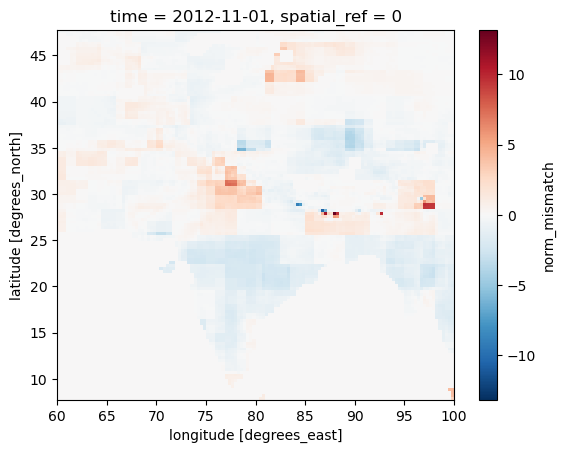

In [19]:
mds = mismatch_ds.transpose('time', 'lat', 'lon')
mds['norm_mismatch'][127,:,:].plot()